# 1 Data overview

In this notebook we will catalogue all the HSC and VISTA image information required for processing. The HSC image corners will be used to find the relevant VISTA images required for swarping to the HSC pixel base.

In [1]:
import glob

from astropy.table import Table, Column
from astropy.io import fits
from astropy.wcs import WCS

import matplotlib.pyplot as plt

import numpy as np

import os

In [2]:
def data_loc():
    """Return data locations depending on machine used
    
    Outputs
    =======
    
    """
    if os.path.exists('../local.yml'):
        data_loc = "/Users/rs548/GitHub/lsst-ir-fusion/data_local/"
    else:
        data_loc = "~/rds/"
    return data_loc
data_loc = data_loc()

In [3]:
data_loc

'/Users/rs548/GitHub/lsst-ir-fusion/data_local/'

## 1.1 HSC images
First lets look at the HSC images.

In [4]:
images = glob.glob(data_loc + "**/calexp*.fits", recursive=True)

In [5]:
meta = Table()
meta.add_column(Column(data=images, name="file"))

In [6]:
meta

file
str170
"/Users/rs548/GitHub/lsst-ir-fusion/data_local/public/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/10054/0,0/calexp-HSC-I-10054-0,0.fits"


### 1.1.1 Example image

Lets look at one image to check the format and see how to retrieve the key information

In [7]:
hdu = fits.open(meta[0]['file'])

In [8]:
hdu.info()

Filename: /Users/rs548/GitHub/lsst-ir-fusion/data_local/public/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/10054/0,0/calexp-HSC-I-10054-0,0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   ()      
  1                1 CompImageHDU     34   (4100, 4100)   float32   
  2                1 CompImageHDU     51   (4100, 4100)   int32   
  3                1 CompImageHDU     34   (4100, 4100)   float32   
  4                1 BinTableHDU     40   15615R x 7C   [1J, 1J, 1J, 1J, 1J, 64A, 64A]   
  5                1 BinTableHDU     76   68R x 15C   [1J, 1J, 1J, 1J, 1J, 1J, 1J, 1K, 1J, 1J, 1J, 1J, 1J, 1D, 32A]   
  6                1 BinTableHDU     16   303R x 1C   [1QB(32882)]   
  7                1 BinTableHDU     22   301R x 2C   [1D, 1D]   
  8                1 BinTableHDU    103   233R x 19C   [1K, 1D, 1D, 1K, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1J, 1D, 1D, 1D, 1D, 1D, 1D]   
  9                1 

In [9]:
def cutout_scale(im, num_min = 2.0, num_max = 5.0):
    """
    Takes an image array and returns the vmin and vmax required to scale the image 
    between median + 5 * sigma MAD and median - 2 * sigma MAD
    """

    import numpy as np
    import astropy.stats as apys

    data = im.flatten()   #Return a copy of the array collapsed into one dimension

    try:
        med = np.median(data[np.isnan(data)!=1])
        sigma_MAD = apys.mad_std(data[np.isnan(data)!=1])
    except IndexError:
        med = 0.0
        sigma_MAD = 0.0
    vmax = med + num_max * sigma_MAD
    vmin = med - num_min * sigma_MAD

    return vmin, vmax
vmin, vmax = cutout_scale(hdu[1].data)

In [10]:
hdu[1].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 4100 / length of original image axis                  
NAXIS2  =                 4100 / length of original image axis                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
XTENSION= 'BINTABLE'           / binary table extension                         
WCSAXES =                    2 / Number of WCS axes                             
CRPIX1  =               18000. / Reference pixel on axis 1                      
CRPIX2  =               18000. / Reference pixel on axis 2                      
CRVAL1  =     148.760330578512 / Value at ref. pixel on axis 1                  
CRVAL2  =     3.719008264462

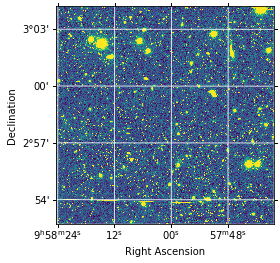

In [11]:


#hdu = fits.open(filename)[0]
#wcs = WCS(hdu.header)
wcs = WCS(hdu[1].header)

plt.subplot(projection=wcs)
plt.imshow(hdu[1].data, vmin=vmin, vmax=vmax, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')

In [12]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 148.760330578512  3.71900826446281  
CRPIX : 18000.0  18000.0  
CD1_1 CD1_2  : -4.666666666663e-05  0.0  
CD2_1 CD2_2  : 0.0  4.666666666663e-05  
NAXIS : 4100  4100

#### Critical imformation
From each image we need:

1. Corner pixels

In [13]:
hdu[1].header['NAXIS1']

4100

In [14]:

ra, dec = wcs.all_pix2world([0,0,hdu[1].header['NAXIS1'],hdu[1].header['NAXIS1']], 
                            [0,hdu[1].header['NAXIS2'],0,hdu[1].header['NAXIS2']], 1) 
print(ra,dec)

[149.60124143 149.6014238  149.40971945 149.40986029] [2.87875888 3.07003912 2.87888383 3.0701724 ]


### 1.2.2 Run on all images
Now lets loop over all the images

In [15]:
meta.add_column(Column(data=np.full(len(meta),  np.nan), name='ra_0_0'))
meta.add_column(Column(data=np.full(len(meta),  np.nan), name='ra_0_y'))
meta.add_column(Column(data=np.full(len(meta),  np.nan), name='ra_x_0'))
meta.add_column(Column(data=np.full(len(meta),  np.nan), name='ra_x_y'))
meta.add_column(Column(data=np.full(len(meta),  np.nan), name='dec_0_0'))
meta.add_column(Column(data=np.full(len(meta),  np.nan), name='dec_0_y'))
meta.add_column(Column(data=np.full(len(meta),  np.nan), name='dec_x_0'))
meta.add_column(Column(data=np.full(len(meta),  np.nan), name='dec_x_y'))
meta.add_column(Column(data=np.full(len(meta),  0), name='size'))

In [16]:

for im in meta:
    file = im["file"]
    #print(file)
    hdu = fits.open(file)
    wcs = WCS(hdu[1].header)
    ra, dec = wcs.all_pix2world([0,0,hdu[1].header['NAXIS1'],hdu[1].header['NAXIS1']], 
                            [0,hdu[1].header['NAXIS2'],0,hdu[1].header['NAXIS2']], 1) 
    im['ra_0_0'] = ra[0]
    im['ra_0_y'] = ra[1]
    im['ra_x_0'] = ra[2]
    im['ra_x_y'] = ra[3]
    im['dec_0_0'] = dec[0]
    im['dec_0_y'] = dec[1]
    im['dec_x_0'] = dec[2]
    im['dec_x_y'] = dec[3]   
    im['size'] =  os.stat(im['file']).st_size

In [17]:
meta.show_in_notebook()

idx,file,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,size
0,"/Users/rs548/GitHub/lsst-ir-fusion/data_local/public/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/10054/0,0/calexp-HSC-I-10054-0,0.fits",149.60124143150958,149.60142380055666,149.40971944781666,149.40986028949584,2.878758884472921,3.070039119384859,2.878883831353908,3.0701723953854674,196171200


In [18]:
meta.write('./hsc_images_overview.csv', overwrite=True)

## 1.2 VISTA images

Now lets investigate the VISTA images.

In [19]:
v_files = glob.glob(data_loc + "private/VISTA/**/*.fit", recursive=True)

In [20]:
v_files

['/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00306_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00298_st.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00291.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00285.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00284.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00290.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00290_st_conf.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00279.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00286.fit',
 '/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00292.fi

In [21]:
v_hdu = fits.open(data_loc + 'private/VISTA/VIDEO/20180911/v20180911_00282_st.fit')

In [22]:
v_hdu.info()

Filename: /Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00282_st.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     360   ()      
  1  DET1.CHIP1    1 CompImageHDU    273   (2126, 2132)   int32   
  2  DET1.CHIP2    1 CompImageHDU    273   (2126, 2133)   int32   
  3  DET1.CHIP3    1 CompImageHDU    273   (2126, 2133)   int32   
  4  DET1.CHIP4    1 CompImageHDU    273   (2126, 2133)   int32   
  5  DET1.CHIP5    1 CompImageHDU    273   (2126, 2132)   int32   
  6  DET1.CHIP6    1 CompImageHDU    273   (2125, 2131)   int32   
  7  DET1.CHIP7    1 CompImageHDU    273   (2125, 2132)   int32   
  8  DET1.CHIP8    1 CompImageHDU    273   (2126, 2131)   int32   
  9  DET1.CHIP9    1 CompImageHDU    273   (2126, 2132)   int32   
 10  DET1.CHIP10    1 CompImageHDU    273   (2125, 2131)   int32   
 11  DET1.CHIP11    1 CompImageHDU    273   (2126, 2131)   int32   
 12  DET1.CHIP12    1 CompImageHDU    27

In [23]:
v_hdu[1].header

 [astropy.io.fits.verify]


XTENSION= 'IMAGE   '           / binary table extension                         
BITPIX  =                   32 / data type of original image                    
NAXIS   =                    2 / dimension of original image                    
NAXIS1  =                 2126 / length of original image axis                  
NAXIS2  =                 2132 / length of original image axis                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
EXTNAME = 'DET1.CHIP1'         / Extension name                                 
ORIGIN  = 'ESO     ' / European Southern Observatory                            
DATE    = '2018-09-12T05:31:46.1448' / Date the file was written                
EXPTIME =                  30. / Corrected to ndit = 1                          
MJD-OBS =       58373.22962175 / Obs start 2018-09-12T05:30:39.319              
DATE-OBS= '2018-09-12T05:30:

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


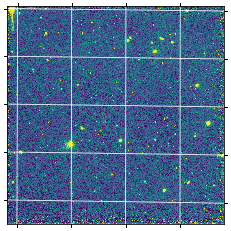

In [24]:
def plot_fits(im_hdu):
    wcs = WCS(im_hdu.header)
    vmin, vmax = cutout_scale(im_hdu.data)
    plt.subplot(projection=wcs)
    plt.imshow(im_hdu.data, vmin=vmin, vmax=vmax, origin='lower')
    plt.grid(color='white', ls='solid')
    plt.xlabel('Right Ascension')
    plt.ylabel('Declination')
    
plot_fits(v_hdu[4])

In [25]:
w = WCS(v_hdu[1].header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


In [26]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZPN'  'DEC--ZPN'  
CRVAL : 52.6386303243784  -28.7291928043803  
CRPIX : 5398.861  6878.556  
CD1_1 CD1_2  : -2.72686616186259e-07  -9.4830861277889e-05  
CD2_1 CD2_2  : 9.48187710823851e-05  -2.80331351309525e-07  
NAXIS : 2126  2132

In [27]:
ra, dec = w.all_pix2world([0,0,v_hdu[1].header['NAXIS1'],v_hdu[1].header['NAXIS1']], 
                            [0,v_hdu[1].header['NAXIS2'],0,v_hdu[1].header['NAXIS2']], 1) 
print(ra,dec)

[53.38140769 53.15307757 53.38077003 53.15247688] [-29.23278836 -29.23578033 -29.03352999 -29.03602169]


In [28]:
v_meta = Table()
v_meta.add_column(Column(data=v_files, name="file"))

In [29]:
v_meta.add_column(Column(data=np.full(len(v_meta),  np.nan), name='ra_0_0'))
v_meta.add_column(Column(data=np.full(len(v_meta),  np.nan), name='ra_0_y'))
v_meta.add_column(Column(data=np.full(len(v_meta),  np.nan), name='ra_x_0'))
v_meta.add_column(Column(data=np.full(len(v_meta),  np.nan), name='ra_x_y'))
v_meta.add_column(Column(data=np.full(len(v_meta),  np.nan), name='dec_0_0'))
v_meta.add_column(Column(data=np.full(len(v_meta),  np.nan), name='dec_0_y'))
v_meta.add_column(Column(data=np.full(len(v_meta),  np.nan), name='dec_x_0'))
v_meta.add_column(Column(data=np.full(len(v_meta),  np.nan), name='dec_x_y'))
v_meta.add_column(Column(data=np.full(len(v_meta),  0), name='size'))

In [30]:
for im in v_meta:
    file = im["file"]
    #print(file)
    hdu = fits.open(file)
    wcs = WCS(hdu[1].header)
    ra, dec = wcs.all_pix2world([0,0,hdu[1].header['NAXIS1'],hdu[1].header['NAXIS1']], 
                            [0,hdu[1].header['NAXIS2'],0,hdu[1].header['NAXIS2']], 1) 
    im['ra_0_0'] = ra[0]
    im['ra_0_y'] = ra[1]
    im['ra_x_0'] = ra[2]
    im['ra_x_y'] = ra[3]
    im['dec_0_0'] = dec[0]
    im['dec_0_y'] = dec[1]
    im['dec_x_0'] = dec[2]
    im['dec_x_y'] = dec[3]   
    im['size'] =  os.stat(im['file']).st_size

 [astropy.io.fits.verify]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [31]:
v_meta.show_in_notebook()

idx,file,ra_0_0,ra_0_y,ra_x_0,ra_x_y,dec_0_0,dec_0_y,dec_x_0,dec_x_y,size
0,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00306_st.fit,53.16960962664129,52.9417372796888,53.169311373819596,52.94147293466295,-29.050603886952178,-29.053289092590642,-28.85131824807178,-28.85350402435093,62478720
1,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00298_st.fit,53.170115975679394,52.94192444423179,53.16986846536143,52.94171320737533,-29.142095042469904,-29.14482997691752,-28.942758663802266,-28.944994239597225,62902080
2,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00291.fit,53.16750370982673,52.94823488142015,53.16776697553997,52.94853205002967,-29.231251379334815,-29.23335319198977,-29.039345897685912,-29.040985372270455,76224960
3,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00285.fit,53.37475041099086,53.15549020454032,53.3745483897988,53.15532092233543,-29.22963672172046,-29.232144152491493,-29.037731183428242,-29.039776214483123,76440960
4,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00284.fit,53.37130562075878,53.1520413701525,53.37110348909808,53.15187200962848,-29.231525665150905,-29.23403317516415,-29.03962012694445,-29.041665237206285,76400640
5,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00290.fit,53.16513177759808,52.94585459442335,53.16539483307966,52.94615161926092,-29.235152956999922,-29.237254933020488,-29.043247475120623,-29.044887113118488,76285440
6,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00290_st_conf.fit,53.170927433559896,52.94244842534808,53.170671996674024,52.94223099553168,-29.233886080840954,-29.23660175902271,-29.03438802393141,-29.036603527042438,24647040
7,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00279.fit,53.37943008805888,53.16037028705753,53.37923354407188,53.16020488802153,-29.135803892019943,-29.13830739012502,-28.943898349528144,-28.945939449638413,76487040
8,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00286.fit,53.372009459284264,53.15275645925189,53.37180763494589,53.15258731661067,-29.22627030073997,-29.228777590295042,-29.034364762295017,-29.03640965219672,76452480
9,/Users/rs548/GitHub/lsst-ir-fusion/data_local/private/VISTA/VIDEO/20180911/v20180911_00292.fit,53.16102380411639,52.941751494739485,53.161286982236476,52.94204860344631,-29.232877045030907,-29.23497892575371,-29.040971563285982,-29.04261110595826,76236480


In [32]:
v_meta.write('./vista_images_overview.csv', overwrite=True)